# Index research based on Shiller dataset

The purpose of this project is to evaluate the predictive power of major price and economic indicators on S&P 500 returns 

Dataset source: http://www.econ.yale.edu/~shisller/data.htm

Named as: FinancialMarketData.xlsx


In [56]:
# %% 1 packages
# can use "conda info --envs" to check default environment in terminal

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# for datetime plotting
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# more plotting
import seaborn as sns

# machine learning & numpy
import numpy as np
from sklearn import linear_model # for predictive model
from sklearn.model_selection import train_test_split #for splitting
from yellowbrick.regressor import ResidualsPlot

# file export
import openpyxl

In [40]:
# %% 2 import & explore data
df = pd.read_excel('SP500_Index_Research_FinancialMarketData.xlsx', 
                   sheet_name = "YearlyMacro")
print(df.dtypes)

DateFmt                float64
Price                  float64
Dividend               float64
Earnings               float64
CPI                    float64
DateFraction           float64
RateGS10               float64
RealSP500              float64
RealDividend           float64
RealEarnings           float64
CAPE                   float64
Source                  object
LastUpdated     datetime64[ns]
Date            datetime64[ns]
dtype: object


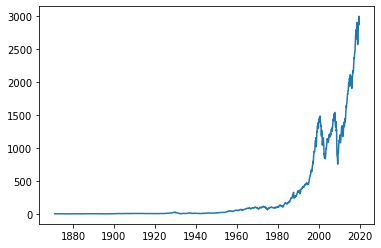

In [41]:
# plot data
# fix for using IPython/Spyder
# %matplotlib qt5
fig, ax  = plt.subplots()
ax.plot(df['DateFraction'],df['Price'])

# ax1 = ax.twinx()
# ax1.plot(summary['DGS10'], color = 'r')

In [48]:
# %% 3 create columns to complete analysis

# future returns (dependent variable)
df['SP500FwdYr01'] = df['Price'].shift(-12) #next year
df['SP500FwdYr01Returns']  = df['SP500FwdYr01'] /df['Price'] - 1

df['SP500FwdYr10'] = df['Price'].shift(-120) #next 10 yrs
df['SP500FwdYr10Returns']  = (df['SP500FwdYr10'] /df['Price'])**(.1) - 1

# pick independent variables
df['InflationTrailing5yrFactor'] = df['CPI'] / df['CPI'].shift(60) #check previous 

df['PERatio'] = df['Price'] / df['Earnings']
df['Earnings10yr'] = df['Earnings'].rolling(window = 120).mean()  # last 10 yrs
df['Earnings10yrGrowthRate'] = (df['Earnings10yr']/df['Earnings10yr'].shift(120))**(.1)-1 # last 10 yrs 
# TODO try different growth rate
df['Earnings10yrAdj'] = df['Earnings10yr'] * (1+df['Earnings10yrGrowthRate'])**5 \
    * df['InflationTrailing5yrFactor']
df['PERatio10yrAdj'] =  df['Price'] / df['Earnings10yrAdj']

# such as target price 
df['Targetprice1yr']  = df['Earnings'] /(df['RateGS10']/100)
df['Targetprice1yrReturn'] = df['Targetprice1yr'] /df['Price']  -1  
df['Targetprice10yr']  = df['Earnings10yrAdj'] /(df['RateGS10']/100) \
    * (1+ df['Earnings10yrGrowthRate'])**10 # includes growth
df['Targetprice10yrReturn'] = (df['Targetprice10yr'] /df['Price'])**(.1)  -1 

#trim file
df = df.dropna()

#check results
print(df.head())

     DateFmt  Price  Dividend  Earnings   CPI  DateFraction  RateGS10  \
587  1919.12   8.92    0.5300    0.9300  18.9   1919.958333  4.930833   
588  1920.01   8.83    0.5283    0.9192  19.3   1920.041667  4.970000   
589  1920.02   8.10    0.5267    0.9083  19.5   1920.125000  4.980000   
590  1920.03   8.67    0.5250    0.8975  19.7   1920.208333  4.990000   
591  1920.04   8.60    0.5233    0.8867  20.3   1920.291667  5.000000   

      RealSP500  RealDividend  RealEarnings  ...  InflationTrailing5yrFactor  \
587  120.906706      7.183919     12.605744  ...                    1.871287   
588  117.206240      7.012464     12.201130  ...                    1.910891   
589  106.413750      6.919521     11.932791  ...                    1.950000   
590  112.745758      6.827165     11.671202  ...                    1.989899   
591  108.529988      6.603924     11.189947  ...                    2.030000   

      PERatio Earnings10yr Earnings10yrGrowthRate  Earnings10yrAdj  \
587  9.591

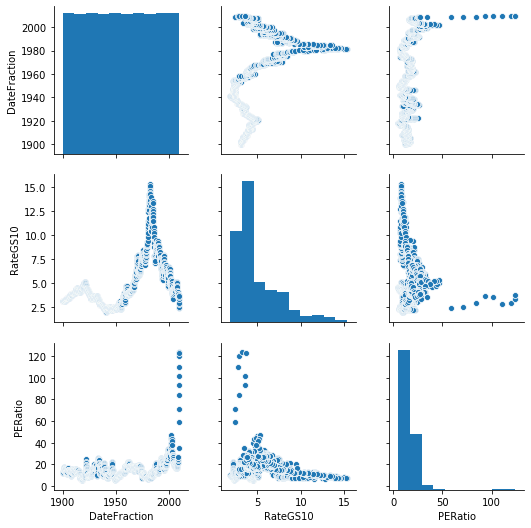

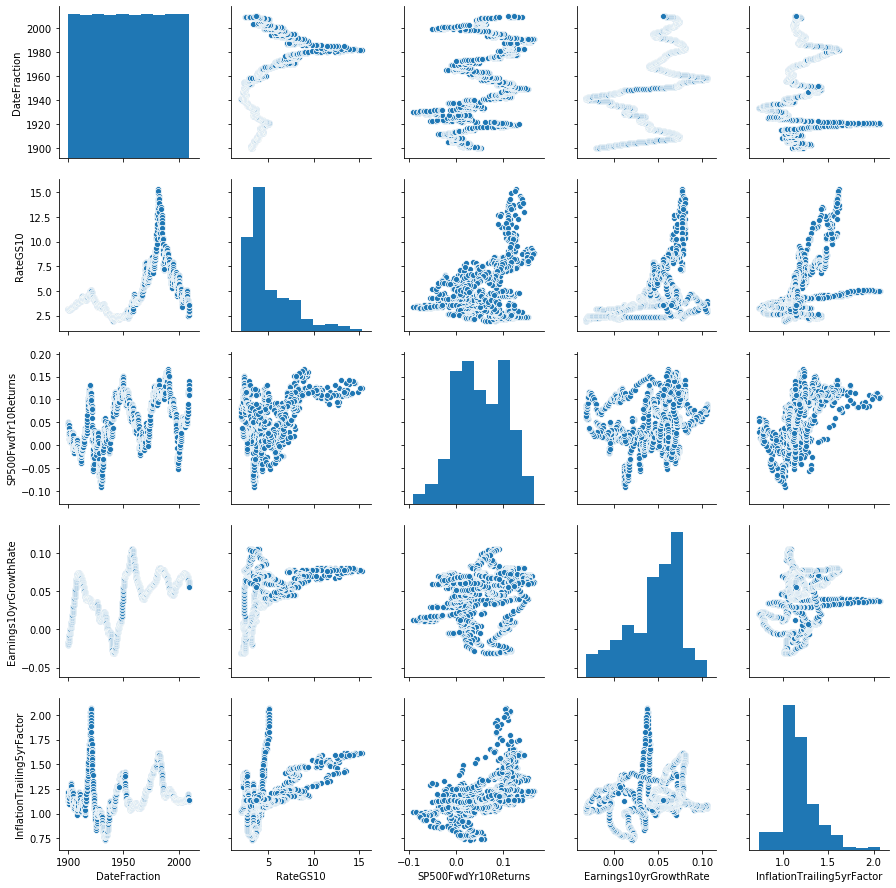

In [43]:
# %% 4 plot data
#fig2, ax2  = plt.subplots()
#ax2.plot(df['PERatio'],df['SP500FwdYr01Returns']) #to fix
sns.pairplot(df[['DateFraction','RateGS10','PERatio']])
sns.pairplot(df[['DateFraction', 'RateGS10',
                 'SP500FwdYr10Returns','Earnings10yrGrowthRate',
                 'InflationTrailing5yrFactor']])


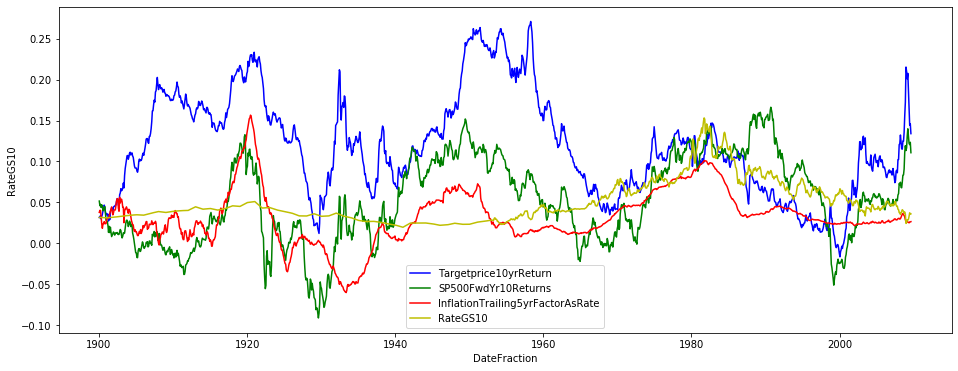

In [44]:
plt.figure(figsize=(16,6))
#fig3, ax3  = plt.subplots(figsize=(16, 6))
sns.lineplot(df['DateFraction'],df['Targetprice10yrReturn'], color = 'b')
#ax3 = plt.twinx()
sns.lineplot(df['DateFraction'],df['SP500FwdYr10Returns'], color = 'g')
sns.lineplot(df['DateFraction'],df['InflationTrailing5yrFactor']**.2-1, color = 'r')
sns.lineplot(df['DateFraction'],df['RateGS10']/100, color = 'y')
plt.legend(labels=['Targetprice10yrReturn','SP500FwdYr10Returns',
                    'InflationTrailing5yrFactorAsRate', 'RateGS10' ])


In [45]:
# export data
df.to_excel('SP500_Index_Research_Results.xlsx', sheet_name = 'sheet1',)

# check relationship with 

In [54]:
# %% 5 fit model

X_all = df.loc[:,['PERatio10yrAdj',
             'InflationTrailing5yrFactor', 'RateGS10']]

y_all = df.loc[:,'SP500FwdYr10Returns']

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.33, random_state=42)

#train classifier
clf = linear_model.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_train, y_train)

params = clf.get_params(deep=True)

print("default (R^2) score:" + np.array2string(clf.score(X_train,y_train)))
print("intercept: " + np.array2string(clf.intercept_))
print("coefficients: " + np.array2string(clf.coef_))

## TODO continuing fitting

# consider adding corporate bonds?

default (R^2) score:0.44947815
intercept: 0.02224994
coefficients: [-0.00431107  0.06659351  0.00245565]


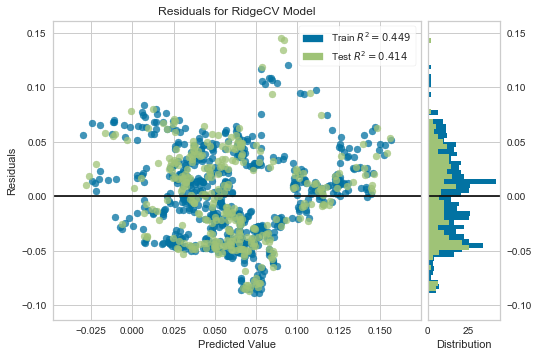

In [57]:
# residual plots
visualizer = ResidualsPlot(clf)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data